<a href="https://colab.research.google.com/github/fakhruddinarif/machine-learning/blob/main/Kuis1_boilerplate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

Pada kuis ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset Labeled Face in Wild (LFW).
Spesifikasi pengerjaan kuis yang harus dipehuni adalah,

1. Setiap label dari dataset LFW harus berisikan minimal 10 gambar (5 poin)
2. Citra yang digunakan merupakan citra RGB / color (5 poin)
3. (Opsional) Lakukan proses pra pengolahan data jika diperlukan (ekstra 10 poin)
4. (Wajib) Gunakan fitur histogram untuk setiap channel citra (35 poin)
5. (Wajib) Gunakan algoritma SVM sebagai model dasar (35 poin)
6. (Wajib) Gunakan metric akurasi, dan *classification report* untuk melihat performa model (20 poin)

## Challenge
Setelah menyelesaikan kuis berdasarkan spesifikasi wajib, Anda diperkenankan untuk

- Menggunakan fitur lain selain histogram (ekstra 20 poin)
- Menggunakan model lain selain SVM (ekstra 10 poin)
- Evalusi dengan metric lain ataupun report dengan *confusion matrix* (ekstra 10 poin)

# Boilerplate

Berikut merupakan boilerplate code yang dapat Anda gunakan sebagai acuan dasar pengerjaan kuis.
Anda diperkenankan untuk **menambah** ataupun **mengurangi** bagian boilerplate yang disediakan.

---

# Preparation

In [1]:
# Load required library
# Import Required Library
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True
faces = fetch_lfw_people(min_faces_per_person=10, color=True)

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')

Total Label: 158
Data dimension: (4324, 62, 47, 3)
Images flatten dimension: (4324, 8742)


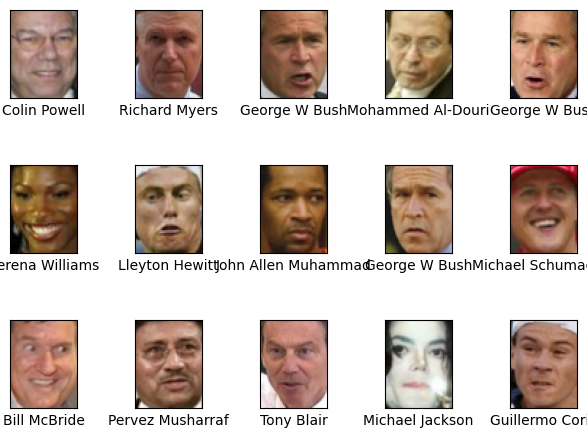

In [3]:
# Check by Plotted Images
# Generate random 15 images
rand_labels = [np.random.randint(0, len(faces.data)) for x in range(0,15)]

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

# Preprocessing

In [4]:
'''
    Pada bagian ini Anda diperbolehkan untuk melakukan proses pra pengolahan data (preprocessing) sesuai dengan kebutuhan. Pra pengolahan data dapat berupa,

    1. Standardisasi nilai fitur ataupun label
    2. Penyesuaian ukuran gambar
    3. Perubahan colorspace gambar
    4. dsb
'''


#3. (Opsional) Lakukan proses pra pengolahan data jika diperlukan (ekstra 10 poin)
from skimage.transform import resize

resize_images = []
for image in faces.images:
    resized_image = resize(image, (100, 100, 3), anti_aliasing=True)
    resize_images.append(resized_image)

# Features Extraction

In [ ]:
# @title
'''
    Pada bagian ini, lakukan proses ekstraksi fitur yang diminta, yaitu histogram tiap channel.
    Terdapat banyak cara untuk melakukan ekstraksi fitur histrogram.

    Hints:
        Salah satu cara untuk melakukan ekstraksi fitur histrogram adalah,
        Anda dapat menggunakan fungsi np.histrogram dari library numpy
'''
# Fungsi untuk menghitung histogram

def compute_histogram(image, grid_size=(4, 4)):
    histograms = []
    img_height, img_width, num_channels = image.shape
    cell_height, cell_width = img_height // grid_size[0], img_width // grid_size[1]

    for row in range(0, img_height, cell_height):
        for col in range(0, img_width, cell_width):
            # Ambil sub-gambar berdasarkan grid yang telah ditentukan
            cell = image[row:row + cell_height, col:col + cell_width]

            # Hitung histogram untuk setiap channel RGB
            for channel in range(num_channels):
                channel_hist, _ = np.histogram(cell[:, :, channel], bins=256, range=(0, 1))
                histograms.append(channel_hist)

    # Flattening daftar histogram menjadi satu array
    return np.concatenate(histograms)

# Ekstraksi histogram dari semua gambar
X = np.array([compute_histogram(img, grid_size=(5,5)) for img in resize_images])

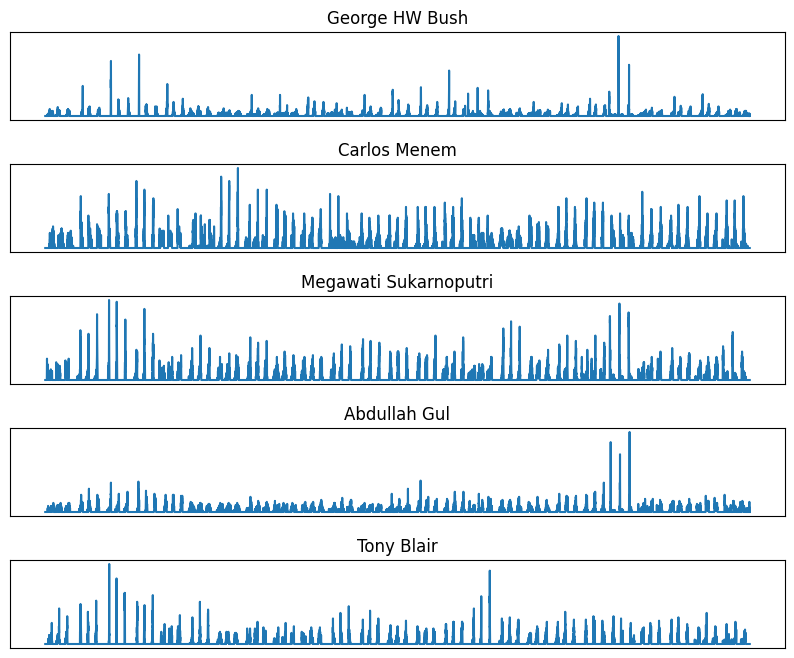

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)

# Lakukan plotting histogram untuk 5 gambar acak
for idx, axis in enumerate(axes):
    random_index = rand_labels[idx]
    axis.plot(X[random_index])  # Plot histogram
    axis.set_title(f"{faces.target_names[faces.target[random_index]]}", fontsize=12)
    axis.set_xticks([])
    axis.set_yticks([])

plt.show()

# Feature Extraction (Challenge)

In [5]:
from skimage.feature import hog

def compute_hog(image):
  fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
  )
  return fd, hog_image

# Ekstraksi HOG dari semua gambar
X_hog = np.array([compute_hog(img)[0] for img in resize_images])

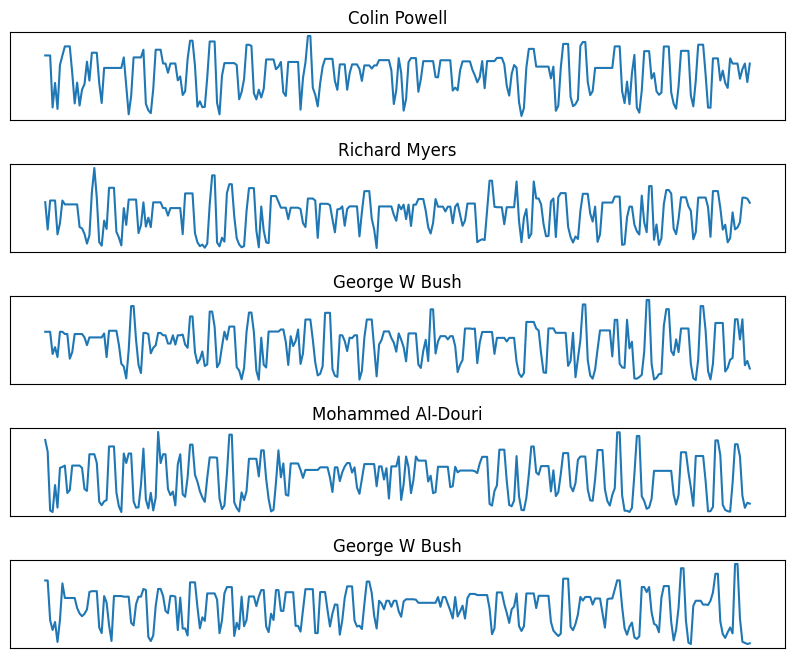

In [6]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)

# Lakukan plotting histogram untuk 5 gambar acak
for idx, axis in enumerate(axes):
    random_index = rand_labels[idx]
    axis.plot(X_hog[random_index])  # Plot histogram
    axis.set_title(f"{faces.target_names[faces.target[random_index]]}", fontsize=12)
    axis.set_xticks([])
    axis.set_yticks([])

plt.show()

# Build Model

In [ ]:
'''
    Pada bagian ini lakukan proses pembuatan model,

    1. Pembuatan data training dan data testing
    2. Pembuatan objek model
    3. Proses fitting model
'''

# Pembagian data training dan testing
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, faces.target, test_size=0.2, random_state=42,stratify=faces.target)

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

model = SVC(C=1,gamma=0.1,kernel="linear")
model.fit(X_train, y_train)

SVC(C=1, gamma=0.1, kernel='linear')

# Build Model (Challenge)

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Pembagian data training dan testing untuk X_hog
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(X_hog, faces.target, test_size=0.2, random_state=42,stratify=faces.target)

# Buat model LDA
model_lda = LinearDiscriminantAnalysis()

# Latih model LDA
model_lda.fit(X_train_hog, y_train_hog)


LinearDiscriminantAnalysis()

# Evaluation

Akurasi Model: 0.33
Classification Report:
                           precision    recall  f1-score   support

             Abdullah Gul       0.33      0.25      0.29         4
             Adrien Brody       0.00      0.00      0.00         2
         Alejandro Toledo       0.11      0.12      0.12         8
             Alvaro Uribe       0.00      0.00      0.00         7
          Amelie Mauresmo       0.00      0.00      0.00         4
             Andre Agassi       0.15      0.29      0.20         7
             Andy Roddick       0.00      0.00      0.00         3
           Angelina Jolie       0.00      0.00      0.00         4
              Ann Veneman       0.00      0.00      0.00         2
          Anna Kournikova       0.50      0.50      0.50         2
            Ari Fleischer       0.00      0.00      0.00         3
             Ariel Sharon       0.22      0.38      0.28        16
    Arnold Schwarzenegger       0.33      0.38      0.35         8
     Atal Bihari V

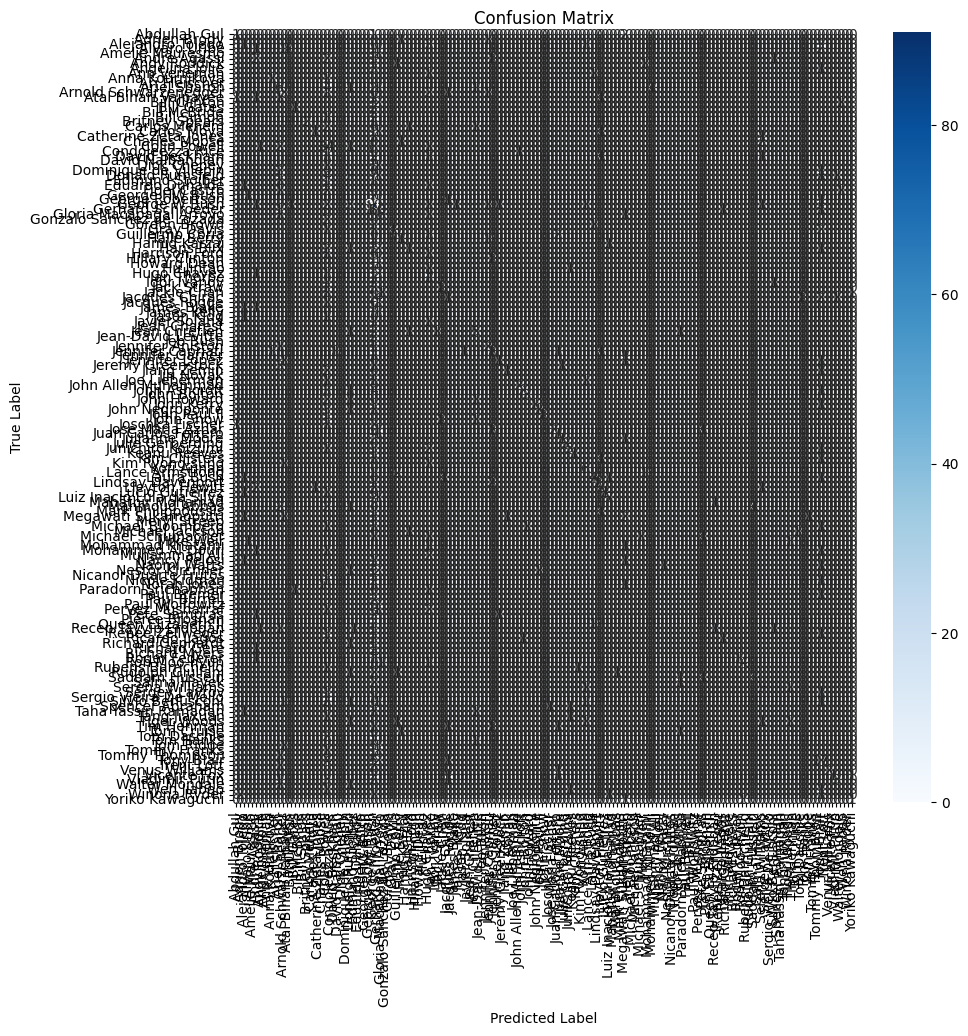

In [ ]:
# Prediksi data testing
y_pred = model.predict(X_test)

# Evaluasi akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy:.2f}")

# Classification report dengan zero_division
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=faces.target_names, zero_division=0))

# Matriks kebingungan
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Evaluation (Challenge)

In [9]:
y_pred = model_lda.predict(X_test_hog)

# Evaluasi akurasi
accuracy = accuracy_score(y_test_hog, y_pred)
print(f"Akurasi Model: {accuracy:.2f}")

Akurasi Model: 0.49
